In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[int(i)] for i in y if i != padding_index])

In [7]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [8]:
# context initialization
with initialize(config_path="../training/conf/", job_name="test_app"):
    cfg = compose(config_name="config", overrides=["+experiment=vqvae"])
    print(OmegaConf.to_yaml(cfg))
    print(cfg)

callbacks:
  model_checkpoint:
    _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val/loss
    save_top_k: 1
    save_last: true
    mode: min
    verbose: false
    dirpath: checkpoints/
    filename: '{epoch:02d}'
  learning_rate_monitor:
    _target_: pytorch_lightning.callbacks.LearningRateMonitor
    logging_interval: step
    log_momentum: false
  watch_model:
    _target_: callbacks.wandb_callbacks.WatchModel
    log: all
    log_freq: 100
  upload_code_as_artifact:
    _target_: callbacks.wandb_callbacks.UploadCodeAsArtifact
    project_dir: ${work_dir}/../text_recognizer
  upload_ckpts_as_artifact:
    _target_: callbacks.wandb_callbacks.UploadCheckpointsAsArtifact
    ckpt_dir: checkpoints/
    upload_best_only: true
  log_image_reconstruction:
    _target_: callbacks.wandb_callbacks.LogReconstuctedImages
    num_samples: 8
criterion:
  _target_: torch.nn.MSELoss
  reduction: mean
datamodule:
  _target_: text_recognizer.data.iam_extended_paragraphs.IAMExte

In [9]:
datamodule = instantiate(cfg.datamodule, mapping=cfg.mapping)
datamodule.prepare_data()
datamodule.setup()
print(datamodule)

2021-08-06 01:28:48.099 | DEBUG    | text_recognizer.data.word_piece_mapping:__init__:37 - Using data dir: /home/aktersnurra/projects/text-recognizer/data/downloaded/iam/iamdb
2021-08-06 01:28:48.299 | INFO     | text_recognizer.data.iam_paragraphs:setup:97 - Loading IAM paragraph regions and lines for None...
2021-08-06 01:29:08.361 | DEBUG    | text_recognizer.data.word_piece_mapping:__init__:37 - Using data dir: /home/aktersnurra/projects/text-recognizer/data/downloaded/iam/iamdb
2021-08-06 01:29:11.692 | DEBUG    | text_recognizer.data.word_piece_mapping:__init__:37 - Using data dir: /home/aktersnurra/projects/text-recognizer/data/downloaded/iam/iamdb
2021-08-06 01:29:11.797 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:68 - IAM Synthetic dataset steup for stage None...
2021-08-06 01:29:24.065 | DEBUG    | text_recognizer.data.word_piece_mapping:__init__:37 - Using data dir: /home/aktersnurra/projects/text-recognizer/data/downloaded/iam/iamdb


IAM Original and Synthetic Paragraphs Dataset
Num classes: 1006
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 19911, 262, 231
Train Batch x stats: (torch.Size([16, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0165), tensor(0.0767), tensor(1.))
Train Batch y stats: (torch.Size([16, 451]), torch.int64, tensor(1), tensor(1003))
Test Batch x stats: (torch.Size([16, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0312), tensor(0.0817), tensor(0.9294))
Test Batch y stats: (torch.Size([16, 451]), torch.int64, tensor(1), tensor(1003))



In [10]:
len(datamodule.train_dataloader())

1245

In [9]:
x, y = next(iter(datamodule.train_dataloader()))

In [ ]:
x.shape

In [20]:
x, y = datamodule.data_train[-3]

In [21]:
y

tensor([1002,    3,  573,   10,  338,  119,  531,   18,    1,    2,   24,   36,
          64,    7,   17,   33,    1,   37,   15,   47,    7,   54,    7,   71,
          24,   54,    7,    1,    2,  743,    1,  511,   13,    7,    1,  742,
        1000,    1,    2,  370,    3,  125,  112,   12,   11,    3,   91,   86,
          20,    1,   26,   20,   36,   20,   31,    7,    4,  100,  508,   48,
        1000,  116,   29,   67,    1,    7,   20,    2,   15,    7,   54,   36,
          13,    1,   17,   54,   23,   71,   15,    1,  653, 1000,  953,    8,
           1,   36,   24,   64,    7,   37,   33, 1000,   91,   35,    3,  507,
         369,   12,  316,    1,   47,   20,   21,   17,   33, 1000,    1,  469,
         324,   33,    1,   54,    7,   46,   54,    7,    2,    2,   23,   24,
          21,    1,    7,    2,   15,   23,   16,   20,   15,    7,    2,   10,
           3,  263,   26,  182,   23,  480,   42, 1000,    3,  260,   40,  100,
         127,  149,    6,    1,   71,   

In [22]:
x.shape

torch.Size([1, 576, 640])

In [23]:
datamodule.mapping.inverse_mapping

{'<b>': 0,
 '<s>': 1,
 '<e>': 2,
 '<p>': 3,
 '0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 'A': 14,
 'B': 15,
 'C': 16,
 'D': 17,
 'E': 18,
 'F': 19,
 'G': 20,
 'H': 21,
 'I': 22,
 'J': 23,
 'K': 24,
 'L': 25,
 'M': 26,
 'N': 27,
 'O': 28,
 'P': 29,
 'Q': 30,
 'R': 31,
 'S': 32,
 'T': 33,
 'U': 34,
 'V': 35,
 'W': 36,
 'X': 37,
 'Y': 38,
 'Z': 39,
 'a': 14,
 'b': 15,
 'c': 16,
 'd': 17,
 'e': 18,
 'f': 19,
 'g': 20,
 'h': 21,
 'i': 22,
 'j': 23,
 'k': 24,
 'l': 25,
 'm': 26,
 'n': 27,
 'o': 28,
 'p': 29,
 'q': 30,
 'r': 31,
 's': 32,
 't': 33,
 'u': 34,
 'v': 35,
 'w': 36,
 'x': 37,
 'y': 38,
 'z': 39,
 ' ': 40,
 '!': 41,
 '"': 42,
 '#': 43,
 '&': 44,
 "'": 45,
 '(': 46,
 ')': 47,
 '*': 48,
 '+': 49,
 ',': 50,
 '-': 51,
 '.': 52,
 '/': 53,
 ':': 54,
 ';': 55,
 '?': 56,
 '\n': 57}

In [24]:
len(datamodule.mapping.mapping)

58

In [25]:
y

tensor([1002,    3,  573,   10,  338,  119,  531,   18,    1,    2,   24,   36,
          64,    7,   17,   33,    1,   37,   15,   47,    7,   54,    7,   71,
          24,   54,    7,    1,    2,  743,    1,  511,   13,    7,    1,  742,
        1000,    1,    2,  370,    3,  125,  112,   12,   11,    3,   91,   86,
          20,    1,   26,   20,   36,   20,   31,    7,    4,  100,  508,   48,
        1000,  116,   29,   67,    1,    7,   20,    2,   15,    7,   54,   36,
          13,    1,   17,   54,   23,   71,   15,    1,  653, 1000,  953,    8,
           1,   36,   24,   64,    7,   37,   33, 1000,   91,   35,    3,  507,
         369,   12,  316,    1,   47,   20,   21,   17,   33, 1000,    1,  469,
         324,   33,    1,   54,    7,   46,   54,    7,    2,    2,   23,   24,
          21,    1,    7,    2,   15,   23,   16,   20,   15,    7,    2,   10,
           3,  263,   26,  182,   23,  480,   42, 1000,    3,  260,   40,  100,
         127,  149,    6,    1,   71,   

In [26]:
datamodule.mapping.get_index("#")

tensor([1004])

In [27]:
convert_y_label_to_string(y, datamodule.mapping, padding_index=3)

'<s>▁problem▁of▁life▁cannot▁be▁solved.▁"therefore▁shall▁1ye▁lay\n▁since▁meeting▁in▁doria▁palace,▁no▁word▁had\n▁there▁is▁an▁easterly▁drift▁special\n▁someone▁to▁love".\n▁do▁for▁world▁using▁my▁hand.\n▁78.▁regression▁estimates▁of▁expenditure▁on\n▁play▁was▁no▁more▁than▁a▁figment▁of\n▁a▁few▁minutes▁later▁from▁a▁nearby▁village,<e><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p><p>

In [28]:
x.shape

torch.Size([1, 576, 640])

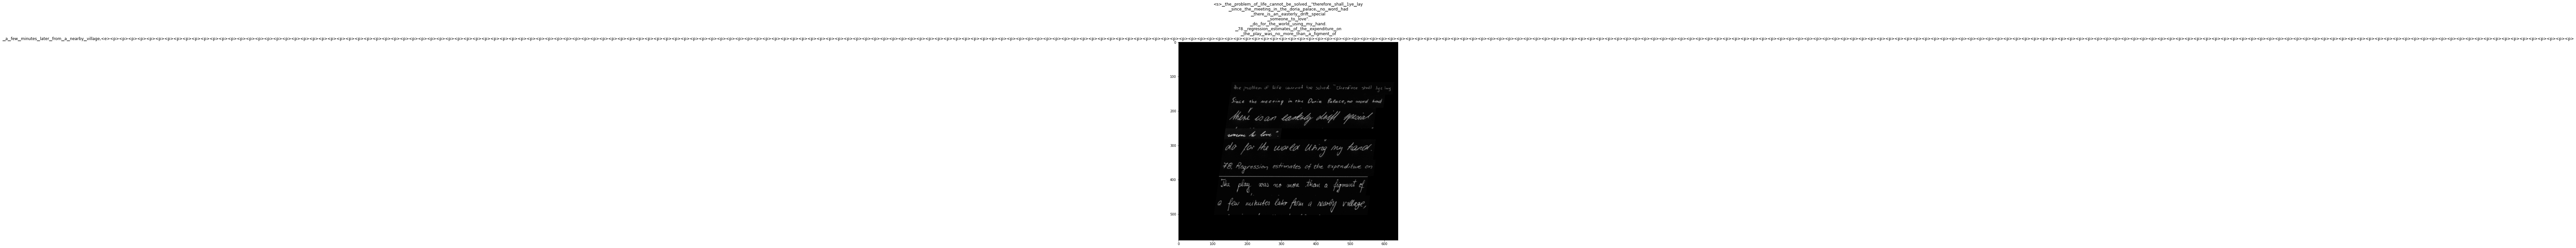

In [29]:
_plot(x[0], vmax=1, title=datamodule.mapping.get_text(y))

In [ ]:
datamodule.mapping["<p>"]

In [ ]:
y[0]

In [ ]:
_plot(x[0, 0], vmax=1, title=convert_y_label_to_string(y[0], datamodule.mapping))

In [ ]:
# Training

for _ in range(5):
    i = random.randint(0, len(dataset.data_train))
    x, y = dataset.data_train[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [ ]:
from einops import rearrange

In [ ]:
x, y = dataset.data_train[2]

In [ ]:
_plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [ ]:
p = 32
patches = rearrange(x.unsqueeze(0), 'b c (h p1) (w p2) -> b c (h w) p1 p2', p1 = p, p2 = p)

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(15):
    ax = fig.add_subplot(1, 15, i + 1)
    ax.imshow(patches[0, 0, i + 160, :, :].squeeze(0), cmap='gray')

In [ ]:
# Testing

for _ in range(5):
    i = random.randint(0, len(dataset.data_test))
    x, y = dataset.data_test[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [ ]:
dataset = IAMSyntheticParagraphs()
dataset.prepare_data()
dataset.setup()
print(dataset)

In [ ]:
# Training

for _ in range(5):
    i = random.randint(0, len(dataset.data_train))
    x, y = dataset.data_train[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))